In [1]:
import cv2
import cv2 as cv
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib
import numpy as np
from dataset import Dataset
from utils import Utils

In [11]:
dataset = Dataset()
# from IPython.display import display, Image
plt.rcParams['figure.dpi'] = 400  # Example: Set DPI to 200
font = {'size'   : 3}

matplotlib.rc('font', **font)
s = lambda x: plt.imshow(x[:, :, ::-1]) if len(x.shape) == 3 else plt.imshow(x, cmap='gray')

In [3]:
def lerp_color(color1, color2, t):
    """
    Linearly interpolate between two colors.
    :param color1: The first color (BGR tuple).
    :param color2: The second color (BGR tuple).
    :param t: Interpolation factor (0.0 to 1.0).
    :return: Interpolated color (BGR tuple).
    """
    return tuple(int(c1 + (c2 - c1) * t) for c1, c2 in zip(color1, color2))


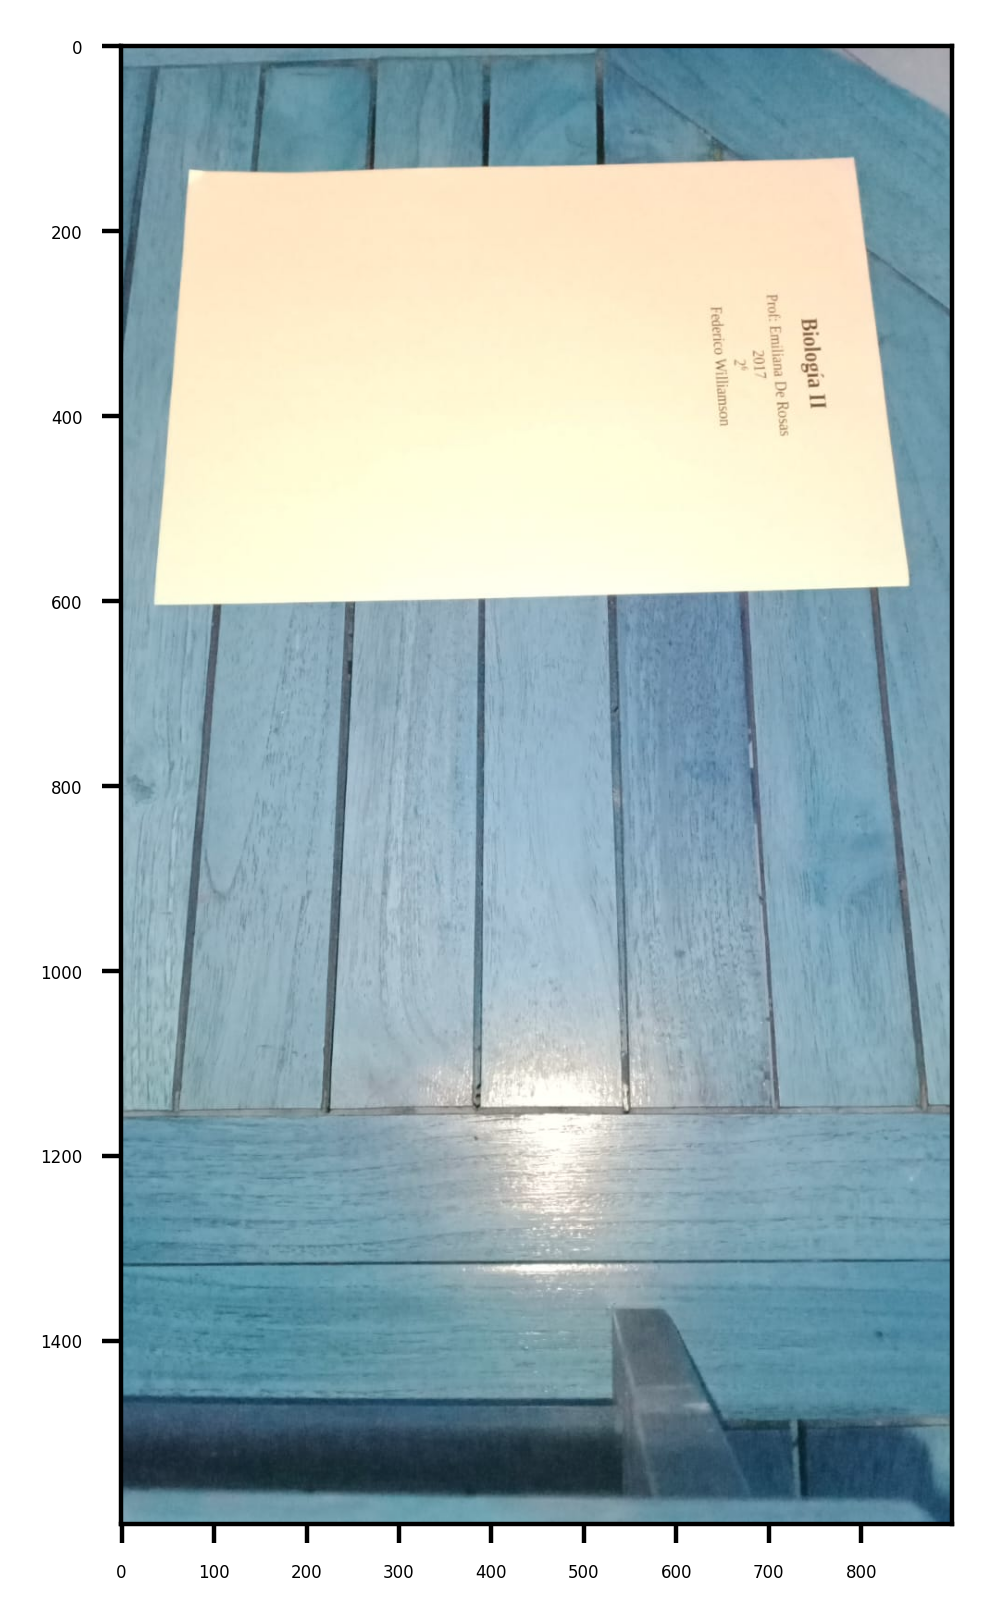

In [17]:
good = [34, 35, 37, 38, 60, 80, 83]
image_path = dataset.images[60]
image = cv.imread(image_path)
s(image[:, :, ::-1])

(33, 1, 2) 105.0
(232, 1, 2) 5213.5
(216, 1, 2) 9503.0
(219, 1, 2) 72344.0
(142, 1, 2) 72387.0
(127, 1, 2) 72132.0
(243, 1, 2) 78214.5
(35, 1, 2) 283.0
(130, 1, 2) 4518.5
(352, 1, 2) 347052.0
(173, 1, 2) 3944.0
(1112, 1, 2) 726262.5


,index,area,rect_area,side_rating,aspect_ratio,overall_rating,ratio_rating,ratio
5,11,726262.5,952214.0,0.019268,1.370892,0.031295,0.043321,0.762709
4,9,347052.0,351041.0,0.060820,1.641597,0.144102,0.227383,0.988637
3,6,78214.5,84395.0,0.014737,3.560353,1.080438,2.146140,0.926767
0,3,72344.0,73859.0,0.070102,3.946508,1.301198,2.532295,0.979488
1,4,72387.0,73542.0,0.087342,3.980292,1.326710,2.566079,0.984295
2,5,72132.0,73381.5,0.082803,4.026314,1.347452,2.612100,0.982973


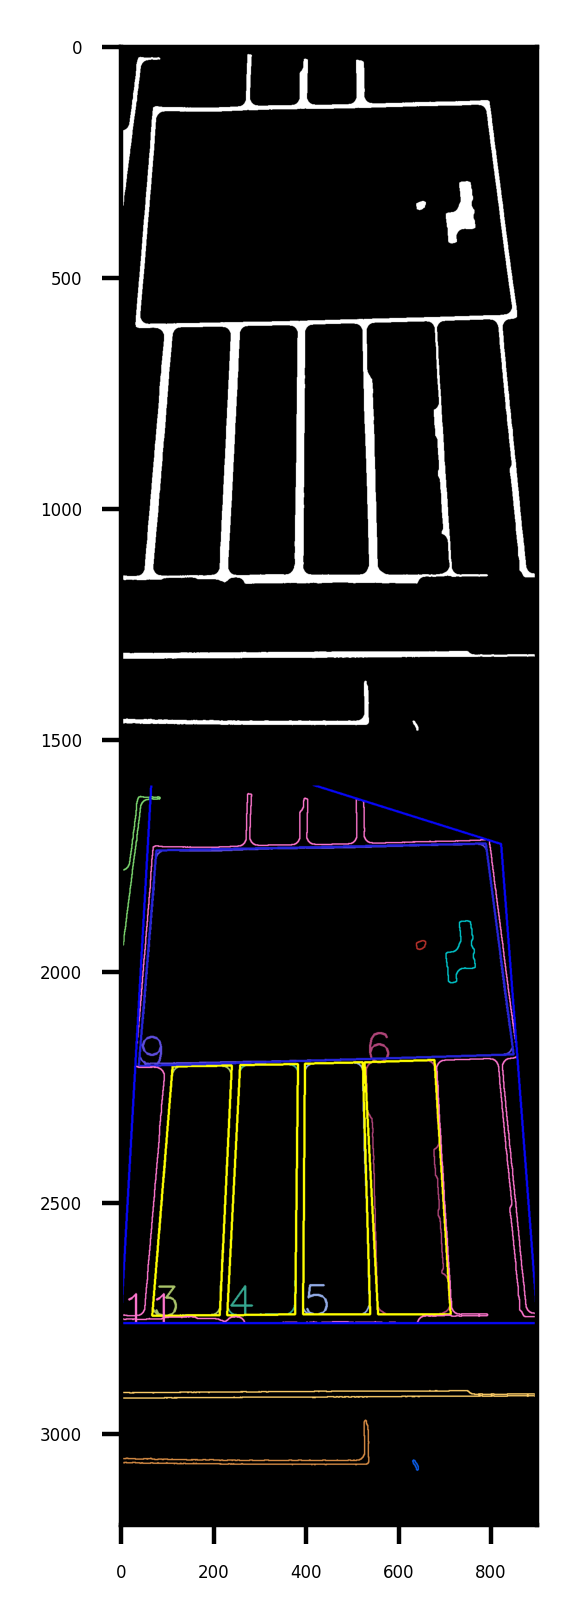

In [19]:
from IPython.display import Image, display
%matplotlib inline

def color_map(idx: int) -> tuple:
    """
    Generate a color map for the given index.
    :param idx: The index to generate the color map for.
    :return: A tuple representing the color in BGR format.
    """
    if idx == 0:
        return (255, 255, 255)  # White for background
    # Interpolate colors between blue and red for the first 10 indices
    elif idx < 5:
        blue = int(255 * (1 - idx / 5))
        red = int(255 * (idx / 5))
        return (blue, 0, red)  # BGR format
    else:
        # For indices >= 10, use a fixed color
        return (0, 0, 0)  # Green for other components


blurred = cv.GaussianBlur(image, (5, 5), 0)
# Apply morphological gradient
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
gradient = cv.morphologyEx(blurred, cv.MORPH_GRADIENT, kernel)
gray_gradient = cv.cvtColor(gradient, cv.COLOR_BGR2GRAY)
canny = cv.Canny(gray_gradient, 50, 200)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (5, 5))
canny = cv.morphologyEx(canny, cv.MORPH_DILATE, kernel)
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (35, 35))
canny = cv.morphologyEx(canny, cv.MORPH_CLOSE, kernel)

# Do connected components, and paint each one in a different color
# components, labels, stats, centroids = cv.connectedComponentsWithStats(255 - canny)
# connected_render = np.zeros_like(image)
# max_area_index = np.argmax(stats[:, cv.CC_STAT_AREA])
# df = []
# for i in range(0, components):
#     x, y, w, h, area = stats[i]
#     col = color_map(i)  # Default to white if not in color_map
#     wh = ((labels == i) * 255).astype(np.uint8)
#     # Find countours on wh
#     points, heirarchy = cv.findContours(wh, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
#     if len(points) == 0:
#         points = np.where(wh > 0)
#         points = np.column_stack((wh[1], wh[0]))
#         area = len(wh[1])
#         is_good = True
#     else:
#         max_area_idx = np.argmax([cv.contourArea(p) for p in points])
#         points = points[max_area_idx]
#         area = cv.contourArea(points)
#         is_good = np.sum((labels == i)) / area
#     rect = cv.approxPolyN(points, 4, epsilon_percentage=2)
#     rect_area = cv.contourArea(rect)
#     df.append({
#         'index': i,
#         'area': area,
#         'rect_area': rect_area,
#         'points': points.shape[0],
#         'is_good': is_good,
#     })
#     # if points.shape[0] > 100000:
#     print(i, area / rect_area, area)
#
#     shape = ((labels == i) * 255).astype(np.uint8)
#     connected_render[labels == i] = col
#     if i == max_area_index:
#         print("I: ", i)
#     connected_render = cv.drawContours(connected_render, [rect], -1, (0, 0, 0), i)

# Connected components doesn't work great because of nested components, E.G. the text.

# Do contour detection on `canny`
df = []
contours, hierarchy = cv.findContours(canny, cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
contour_render = np.zeros_like(image)
for i, contour in enumerate(contours):
    col = np.random.randint(0, 255, size=(3,), dtype=np.uint8)
    cv.drawContours(contour_render, contours, i, col.tolist(), 2)
    area = cv.contourArea(contour)
    print(contour.shape, area)
    if area < 100 * 100:
        continue  # Skip small contours
    # Approximate the contour to a polygon
    approx = cv.approxPolyN(contour, 4)
    # Draw the approximated polygon
    approximation_area = cv.contourArea(approx)
    approx_side_lengths = [np.linalg.norm(approx[0][j] - approx[0][(j + 1) % len(approx[0])]) for j in range(len(approx[0]))]
    side_a_len = approx_side_lengths[0] + approx_side_lengths[2]
    side_b_len = approx_side_lengths[1] + approx_side_lengths[3]
    # Add text with contour index

    cv.putText(contour_render, str(i), tuple(approx[0][2]), cv.FONT_HERSHEY_SIMPLEX, 3, col.tolist(), 3)
    side_a_ratio = approx_side_lengths[0] / approx_side_lengths[2] if approx_side_lengths[2] != 0 else 0
    side_b_ratio = approx_side_lengths[1] / approx_side_lengths[3] if approx_side_lengths[3] != 0 else 0
    aspect_ratio = side_a_len / side_b_len if side_b_len != 0 else 0
    if aspect_ratio < 1:
        aspect_ratio = 1 / aspect_ratio  # Ensure aspect ratio is >= 1
    ratio_rating = abs((2 ** 0.5) - aspect_ratio)
    side_rating = abs(1 - (side_a_ratio + side_b_ratio) / 2)
    overall_rating = (ratio_rating + side_rating) / 2
    cv.drawContours(contour_render, [approx], -1, lerp_color((255,0,0), (0,255,255), overall_rating), 4)
    df.append({
        'index': i,
        'area': area,
        'rect_area': approximation_area,
        # 'side_a': side_a_len,
        # 'side_b': side_b_len,
        # 'side_a_ratio': side_a_ratio,
        # 'side_b_ratio': side_b_ratio,
        'side_rating': side_rating,
        'aspect_ratio': aspect_ratio,
        'overall_rating': overall_rating
    })

s(cv.vconcat([cv.cvtColor(canny, cv.COLOR_GRAY2BGR), contour_render]))
df = pd.DataFrame(df)
df['ratio_rating'] = abs((2 ** 0.5) - df['aspect_ratio'])
df['ratio'] = df['area'] / df['rect_area']
pd.set_option('display.max_rows', 500)
df.sort_values(by=['overall_rating'], ascending=True)

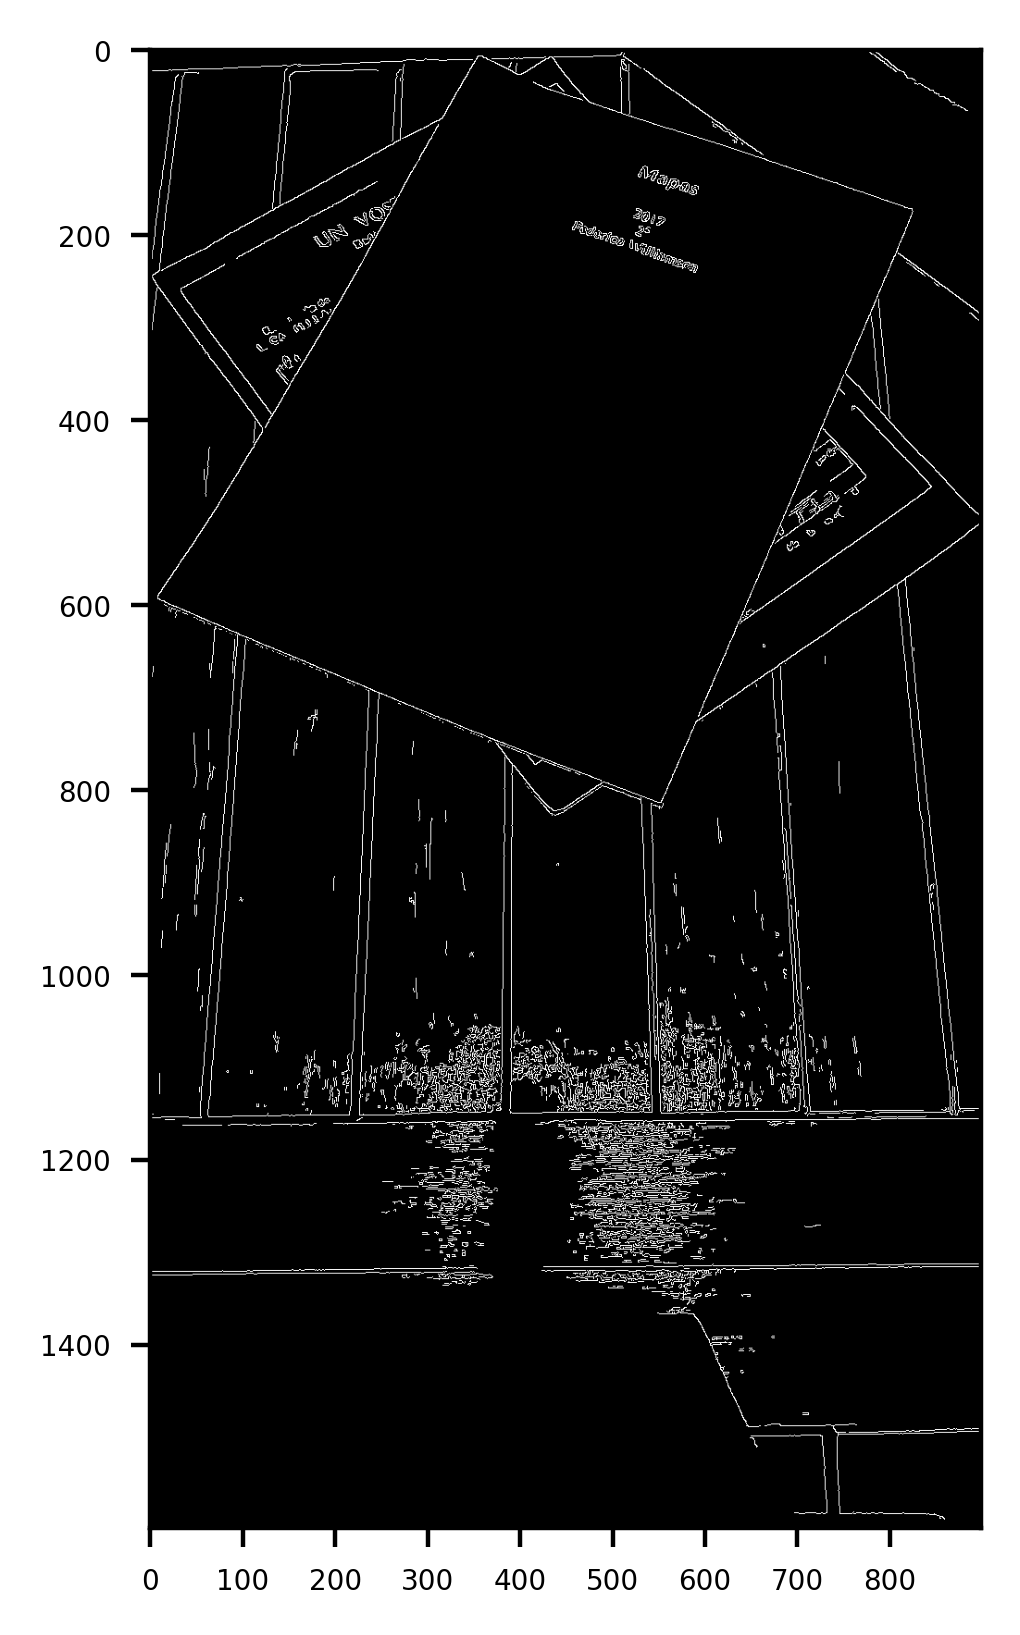

In [6]:
canny = cv.Canny(image, 100, 200)
s(canny)

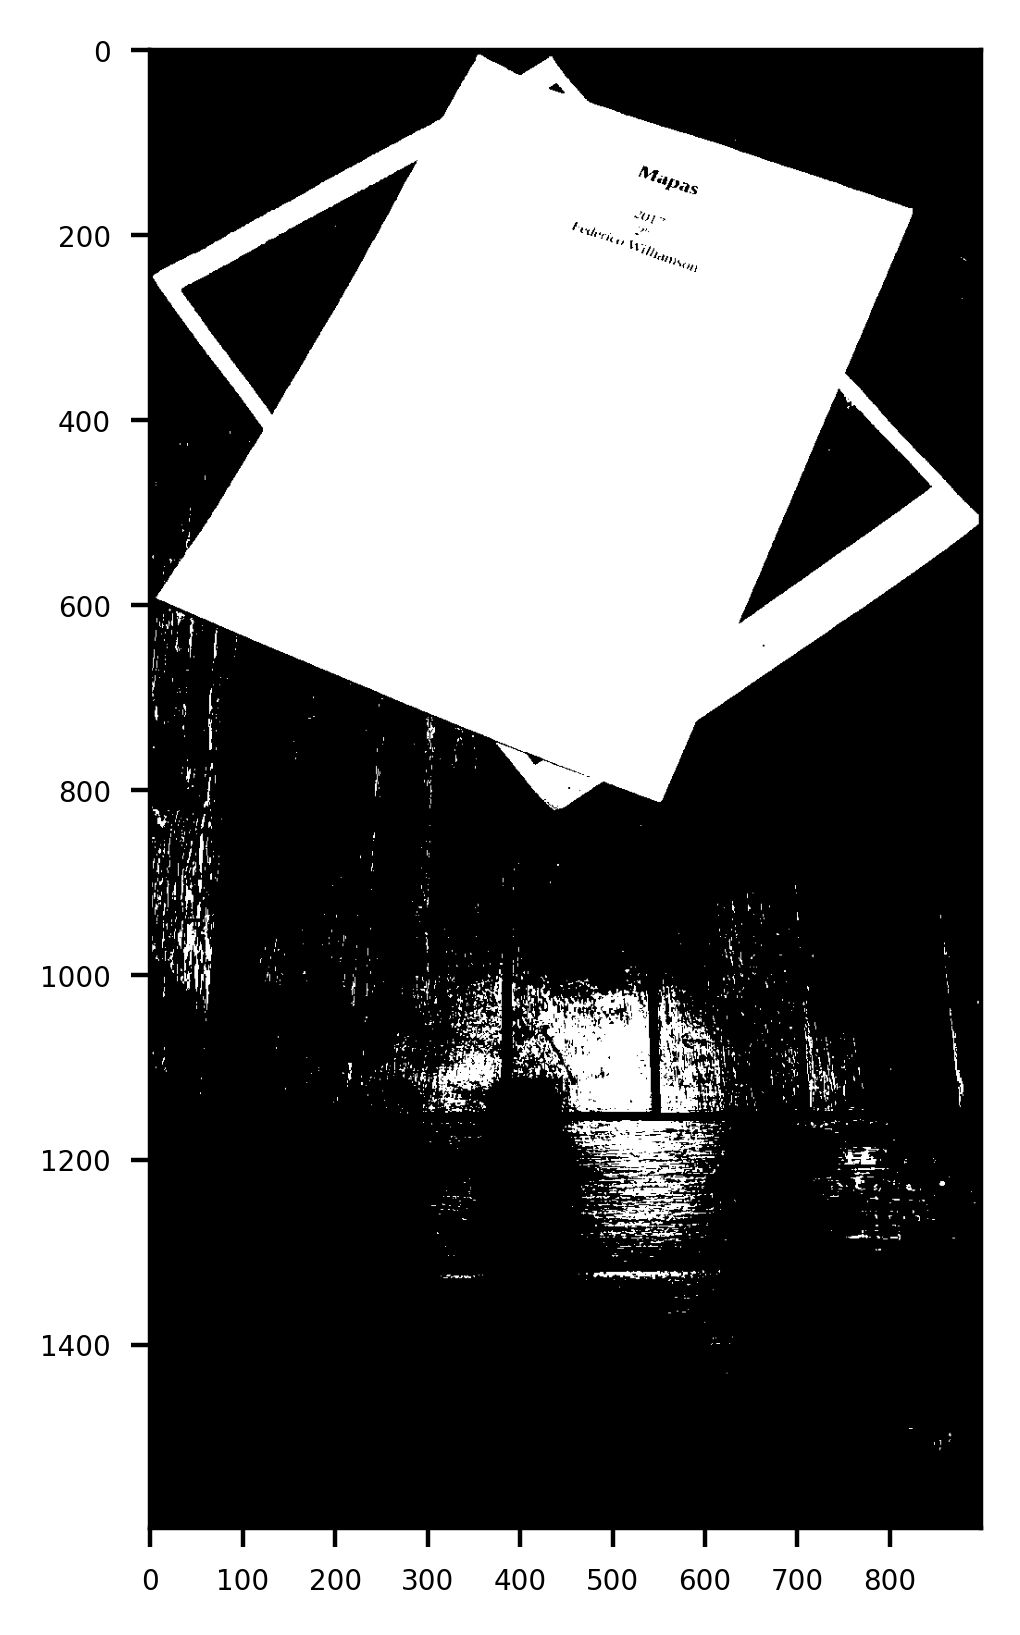

In [7]:
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

_, binary_image = cv.threshold(gray_image, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
s(gray_image)
s(binary_image)

-1 2147483647 0 0 0
0 0 899 1599 1437501


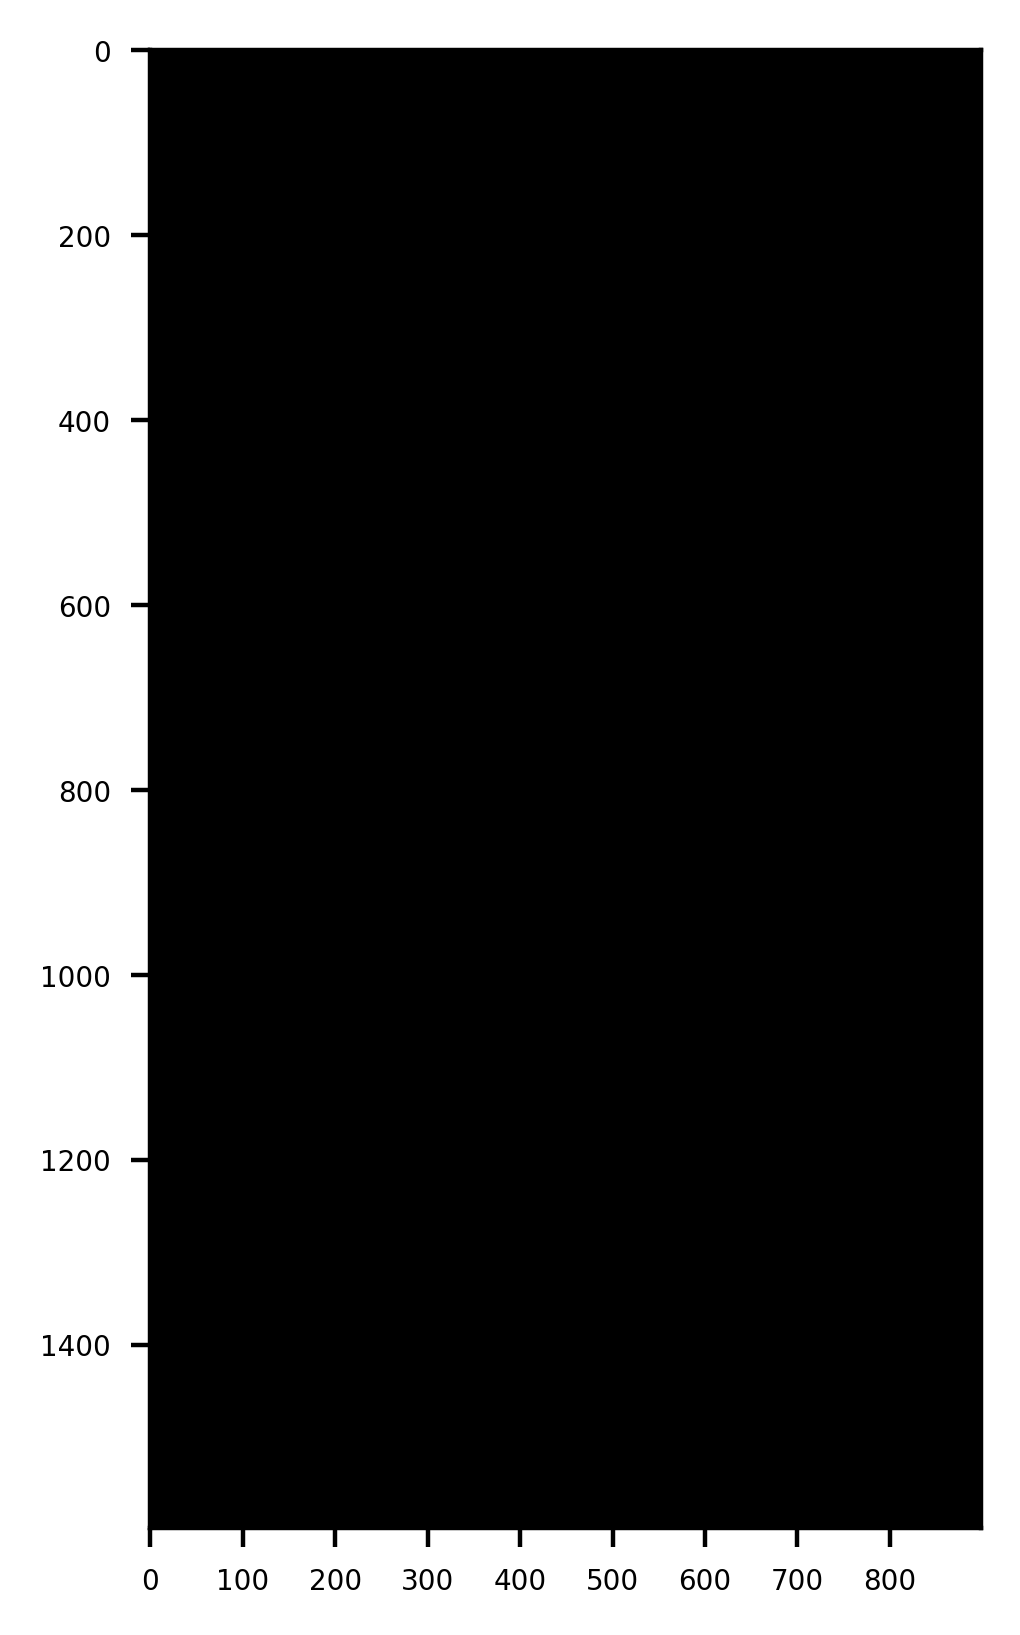

In [8]:
components, labels, stats, centroids = cv.connectedComponentsWithStats(gray_image)

for i in range(0, components):
    x, y, w, h, area = stats[i]
    print(x, y, w, h, area)

s(labels)